## Step-1 First verify the given keras model is working fine 

Using TensorFlow backend.
Model Loaded successfully...


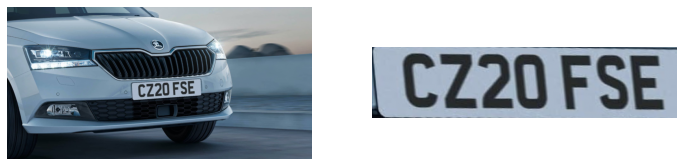

In [1]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from tensorflow.keras.models  import model_from_json
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
import glob

def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Model Loaded successfully...")
        return model
    except Exception as e:
        print(e)
wpod_net_path = "models/wpod-net.json"
wpod_net = load_model(wpod_net_path)

def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin = 608):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

test_image_path = "dataset/plate5.jpeg"
vehicle, LpImg, cor = get_plate(test_image_path)

fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0])

## Summary
- As you can see the keras model file (*.h5) and architecture/configuration file (*.json) is working fine i.e. able to detect number plate from the image.
- In the next step we need to save both model file as well as the configuration file into one single file and make sure that works well (taking one step at a time)

## Step-2 Converting (saving) keras model as a single (*.h5)

A Keras model consists of multiple components:

- The architecture, or configuration, which specifies what layers the model contain, and how they're connected.
- A set of weights values (the "state of the model").
- An optimizer (defined by compiling the model).

The Keras API makes it possible to save all of these pieces to disk at once. Saving everything into a single archive in the TensorFlow SavedModel format (or in the older Keras H5 format). This is the standard practice. This is what we will do in our next step and make sure the new saved tensorflow model file can still detect number plates from provided image file.


In [ ]:
def save_model(path):
    try:
        path = splitext(path)[0]
        #print(splitext(path.split('/')[0]))
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        #print(os.path())
        model.save("models/wpod_net_all_in_one.h5")
        print("Model Saved successfully...")
        return model
    except Exception as e:
        print(e)

import os
wpod_net_path = "models/wpod-net.json"
wpod_net = save_model(wpod_net_path)


In [ ]:
! ls -l models

### Lets verify, this newly created keras all-in-one file is still able to detect number plates from the supplied image

In [ ]:
from tensorflow import keras
all_in_one_model = keras.models.load_model('models/wpod_net_all_in_one.h5')

print(all_in_one_model.outputs)
print(all_in_one_model.inputs)

def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin = 608):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(all_in_one_model, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

import cv2
from local_utils import detect_lp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
test_image_path = "dataset/plate5.jpeg"
vehicle, LpImg,cor = get_plate(test_image_path)

fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0])

## Summary
- We have learned how to save keras model file (*.h5) and the configuration file (*.json) as one file `*.h5`
- We have also verified that, this new all-in-one model file is able to detect number plate from the image, as we wanted
- In the next step we will convert this keras model all-in-one file into tensorflow (*.pb) frozengraph model file and its text representation

## Step - 3 : Convert keras model to TF Frozen model file and its text representation

In [ ]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np


model = keras.models.load_model('models/wpod_net_all_in_one.h5')

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    x=tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

# inspect the layers operations inside your frozen graph definition and see the name of its input and output tensors
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 50)
print("Frozen model layers: ")
for layer in layers:
    print(layer)

print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
# serialize the frozen graph and its text representation to disk.
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="simple_frozen_graph.pb",
                  as_text=False)

#Optional
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="simple_frozen_graph.pbtxt",
                as_text=True)


In [ ]:
model.summary()

In [ ]:
!ls -l frozen_models

## Summary
- In this step we have successfully converted keras h5 file into ternsorflow 2.0 frozen graph

## Step - 4 : Run inferencing using the frozen model

Tensor Input :  Tensor("x:0", shape=(None, None, None, 3), dtype=float32)
Tensor Output:  Tensor("Identity:0", shape=(None, None, None, 8), dtype=float32)


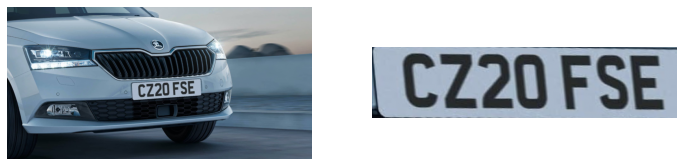

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow.compat.v1 as tf
from local_utils import reconstruct

def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, sess, Dmax=608, Dmin = 608):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    processed_image, Iresized = prepare_image_for_tf_inferencing(vehicle, bound_dim)
    infrencing = sess.run(output_tensor, {'x:0': processed_image})
    np_inferencing = np.squeeze(infrencing)
    _ , LpImg, _, cor = detect_lp_tf(Iresized, np_inferencing, vehicle, lp_threshold=0.5)
    return vehicle, LpImg, cor

def prepare_image_for_tf_inferencing(vehicle, bound_dim):
    min_dim_img = min(vehicle.shape[:2])
    factor = float(bound_dim) / min_dim_img
    w, h = (np.array(vehicle.shape[1::-1], dtype=float) * factor).astype(int).tolist()
    Iresized = cv2.resize(vehicle, (w, h))
    T = Iresized.copy()
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))
    return T, Iresized

def detect_lp_tf(Iresized, np_inferencing, I, lp_threshold):
    L, TLp, lp_type, Cor = reconstruct(I, Iresized, np_inferencing, lp_threshold)
    return L, TLp, lp_type, Cor


## Loading model
sess=tf.InteractiveSession()
frozen_graph="./frozen_models/simple_frozen_graph.pb"
with tf.gfile.GFile(frozen_graph, "rb") as f:
      graph_def = tf.GraphDef()
      graph_def.ParseFromString(f.read())
sess.graph.as_default()
tf.import_graph_def(graph_def)
# Frozen model inputs: 
# [<tf.Tensor 'x:0' shape=(None, None, None, 3) dtype=float32>]
# Frozen model outputs: 
# [<tf.Tensor 'Identity:0' shape=(None, None, None, 8) dtype=float32>]  
input_tensor = sess.graph.get_tensor_by_name("x:0") 
output_tensor = sess.graph.get_tensor_by_name("Identity:0")        
print("Tensor Input : ", input_tensor)
print("Tensor Output: ", output_tensor)
print("..... Extracing Number Plate .......")

test_image_path = "dataset/plate5.jpeg"
vehicle, LpImg,cor = get_plate(test_image_path, sess)


fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0])

## Summary
- In the last step we converted keras h5 model to tensorflow frozen model
- In this step we ran inferencing using tensorflow frozen model

## Step-5 (Optional) : Converting Keras model file to tensorflow (*.pb) model SaveModel format

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('models/wpod_net_all_in_one.h5')
tf.saved_model.save(model, "models")
print("successfully saved keras model file to tensorflow model file")

In [ ]:
! ls -l models/

- `tf.saved_model.save` will generate two directories `assets` , `variables` and the tensorflow model file `saved_model.pb`
- Note that this will save the model in the SavedModel format which is not the same as a .pb file with a frozen graph
- Lets now verify if we can still able to detect number plates from the supplied images using this new tensorflow model file

In [ ]:
from tensorflow import keras
# Just provide the directory name where the TF *.pb (model file saved_model.pb) file is located
tf_model = keras.models.load_model('models')

print(all_in_one_model.outputs)
print(all_in_one_model.inputs)

def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin = 608):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(all_in_one_model, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor
import cv2
from local_utils import detect_lp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
test_image_path = "dataset/plate5.jpeg"
vehicle, LpImg,cor = get_plate(test_image_path)

fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0])

### Summary
- We are able to load the Tensorflow (*.pb) model file and are still able to detect number plate from the image, Great

## Step - 6 : Convert TF *.pb model file to OpenVino IR

In [1]:
mo_tf_path = '/opt/intel/openvino_2021.2.185/deployment_tools/model_optimizer/mo_tf.py'
pb_file = './frozen_models/simple_frozen_graph.pb'
output_dir = './models'
img_height = 224
input_shape = [1,img_height,img_height,3]
input_shape_str = str(input_shape).replace(' ','')
#input_shape_str

#!python {mo_tf_path} --input_model {pb_file} --output_dir {output_dir} --input_shape {input_shape_str} --data_type FP32
#!pip3 install defusedxml networkx test-generator==0.1.1
!python3 $mo_tf_path --input_model $pb_file --output_dir $output_dir --input_shape "$input_shape_str"

/opt/intel/openvino_2021.2.185/deployment_tools/model_optimizer/mo/main.py:85: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if op is 'k':
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/Users/karasing/git/ml_experiments/convert_keras_model_to_tensorflow/./frozen_models/simple_frozen_graph.pb
	- Path for generated IR: 	/Users/karasing/git/ml_experiments/convert_keras_model_to_tensorflow/./models
	- IR output name: 	simple_frozen_graph
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,224,224,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
TensorFlow specific paramete

``` [ ERROR ]  Error while emitting attributes for layer model_1/conv2d_1/BiasAdd/Add/Fused_Add_ (id = 4). It usually means that there is unsupported pattern around this node or unsupported combination of attributes. ```

## Serving Tensorflow Frozen model using TFServing